In [1]:
pip install tsai -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tsai.all import *
from fastai.callback.all import *
import gc
import notebookcfa27bdb31 as ArrayGenerator

In [3]:
df= pd.read_pickle("/kaggle/input/vhr-graduation-project-all/vhr_graduation_project_all.pickle")

In [4]:
raw_X = np.array(df["ts"].to_list())
raw_y = np.array(df["status"])

In [5]:
X, y = ArrayGenerator.generate_dataset_array(dataset_category=8, ts=raw_X, labels=raw_y, split_method="machine")

{'Faults classified': 'Status', 'Channels taken': 'All', 'Labels array': 'multiclass'}


In [6]:
splits = get_splits(y, valid_size=0.2, shuffle=True,show_plot=False)

In [7]:
X_train, y_train = X[splits[0]], y[splits[0]]
X_test, y_test = X[splits[1]], y[splits[1]]

#  reduced overlapping percentage to prevent the data from being
X_train, y_train = ArrayGenerator.apply_sliding_window(
    X_train, y_train, window_size=4096, with_fft=0, overlap_pct=0.6
)
X_test, y_test = ArrayGenerator.apply_sliding_window(
    X_test, y_test, window_size=4096, with_fft=0, overlap_pct=0
)

In [8]:
X_train.shape, X_test.shape # 2048 because of the  FFT 

((1457, 6, 4096), (202, 6, 4096))

In [9]:
train_balance_splits = get_splits(
    y_train, valid_size=0, balance=True, strategy="oversample", shuffle=True,show_plot=False
)
X_train, y_train = X_train[train_balance_splits[0]], y_train[train_balance_splits[0]]
X, y, splits = combine_split_data(
    [X_train, X_test], [y_train, y_test]
)

valid == train


In [10]:
dls = get_ts_dls(X, y, splits=splits, tfms=[None, TSClassification()] , batch_tfms=TSStandardize(), bs=[8, 128])

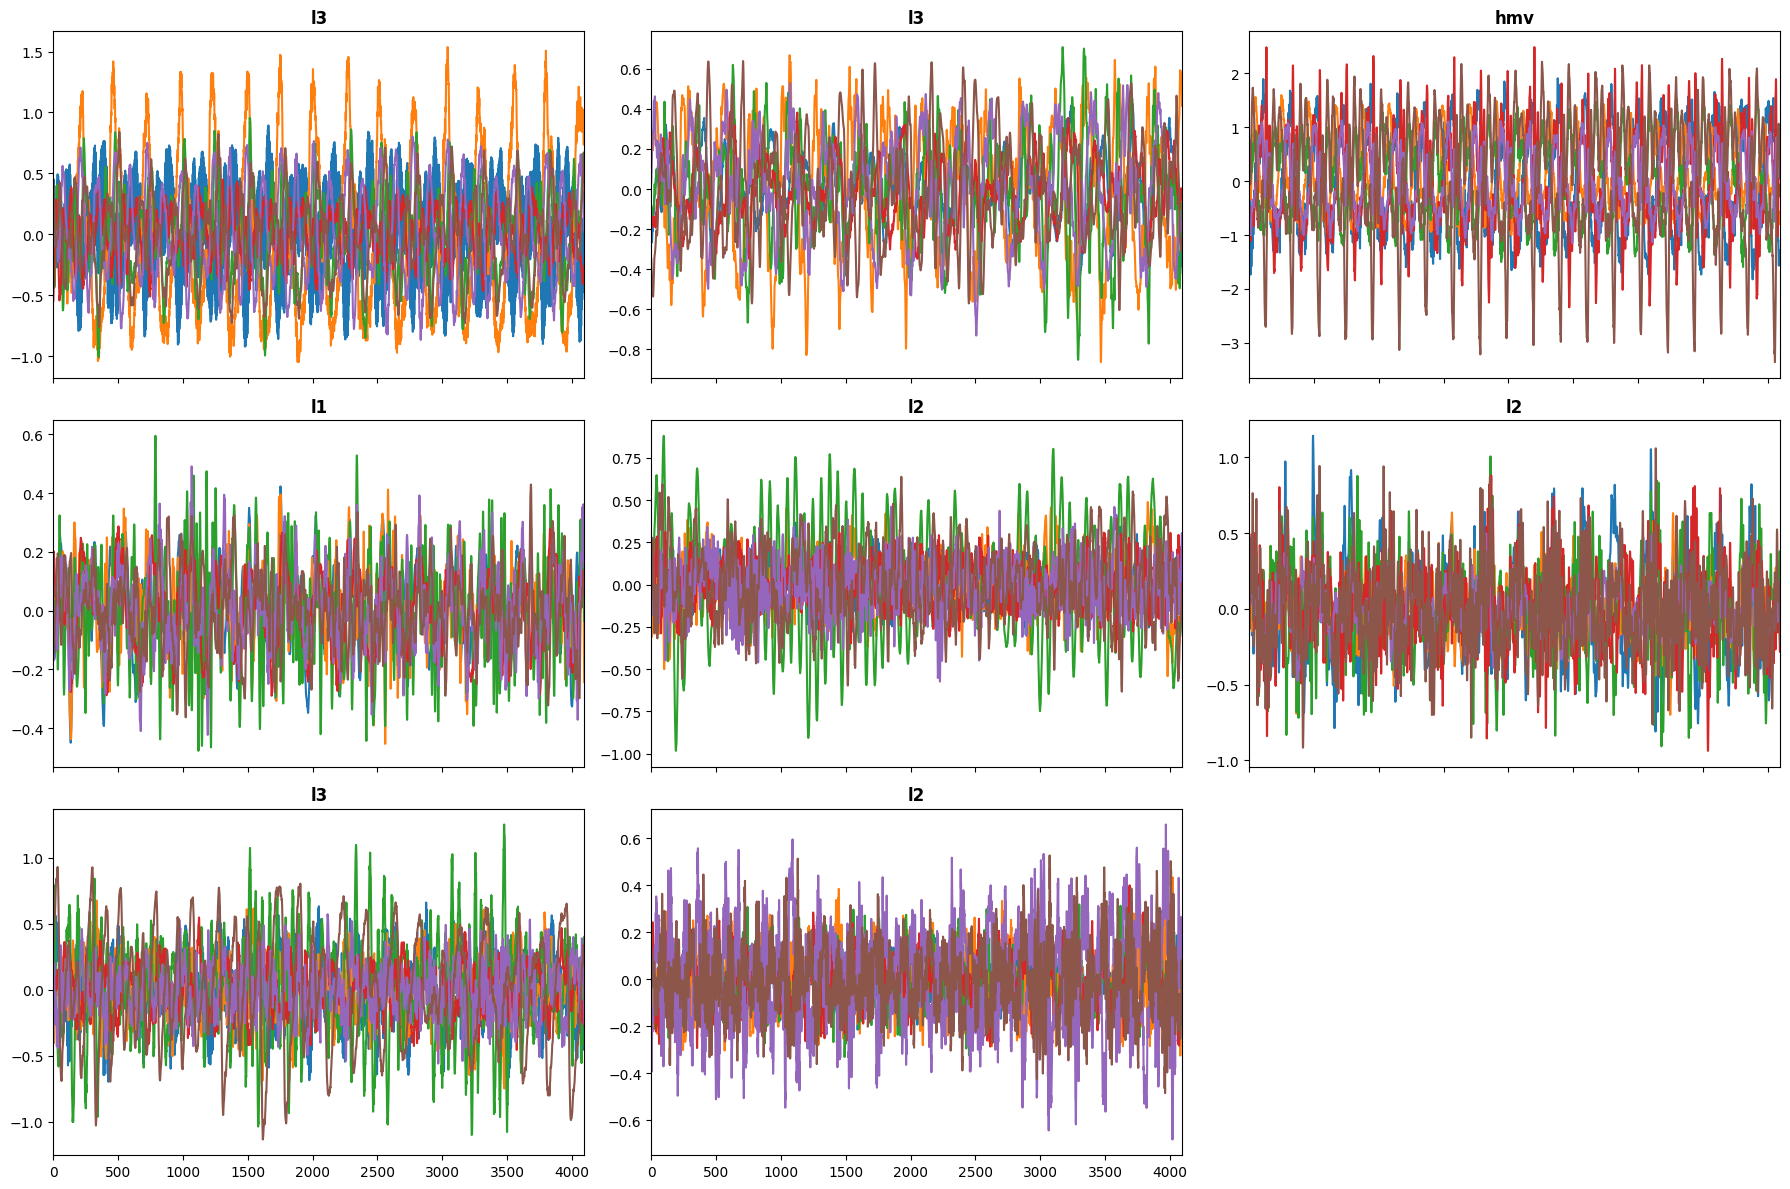

In [11]:
dls.show_batch()

In [12]:
callbacks = [
    PredictionDynamics(),
    EarlyStoppingCallback(monitor='f1_score', comp=np.greater , patience=3),
    SaveModelCallback(monitor='f1_score', comp=np.greater ),
    ShowGraph()
]

In [13]:
model = build_ts_model(InceptionTimePlus,dls=dls)
learn = Learner(dls, model, metrics=[accuracy, Precision(average='micro'), Recall(average='micro'), F1Score(average='micro'), BalancedAccuracy()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score,time
0,0.855585,1.192456,0.485149,0.485149,0.485149,0.485149,0.434155,00:22
1,0.785023,1.052319,0.524752,0.524752,0.524752,0.524752,0.503292,00:21
2,0.725822,1.228264,0.440594,0.440594,0.440594,0.440594,0.481883,00:21
3,0.672591,1.344588,0.465347,0.465347,0.465347,0.465347,0.560221,00:21
4,0.613625,1.536456,0.405941,0.405941,0.405941,0.405941,0.513047,00:21


Better model found at epoch 0 with f1_score value: 0.48514851485148514.


,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,balanced_accuracy_score
3,0.672591,1.344588,0.465347,0.465347,0.465347,0.465347,0.560221


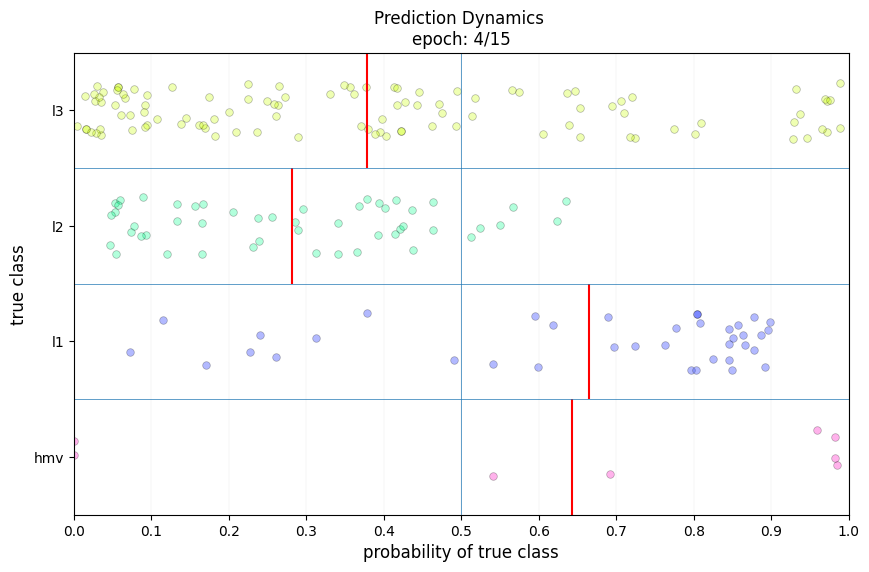

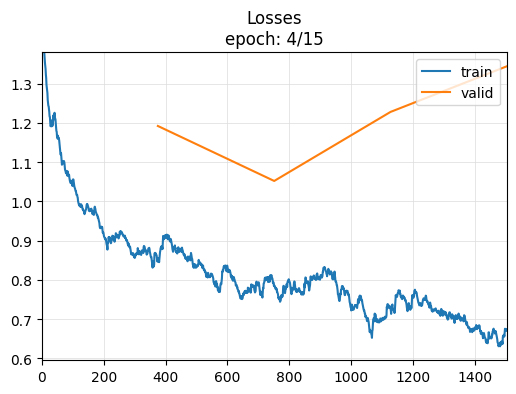

Better model found at epoch 1 with f1_score value: 0.5247524752475248.
No improvement since epoch 1: early stopping


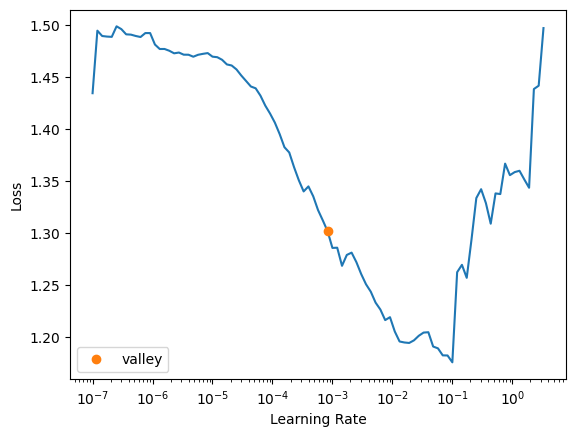

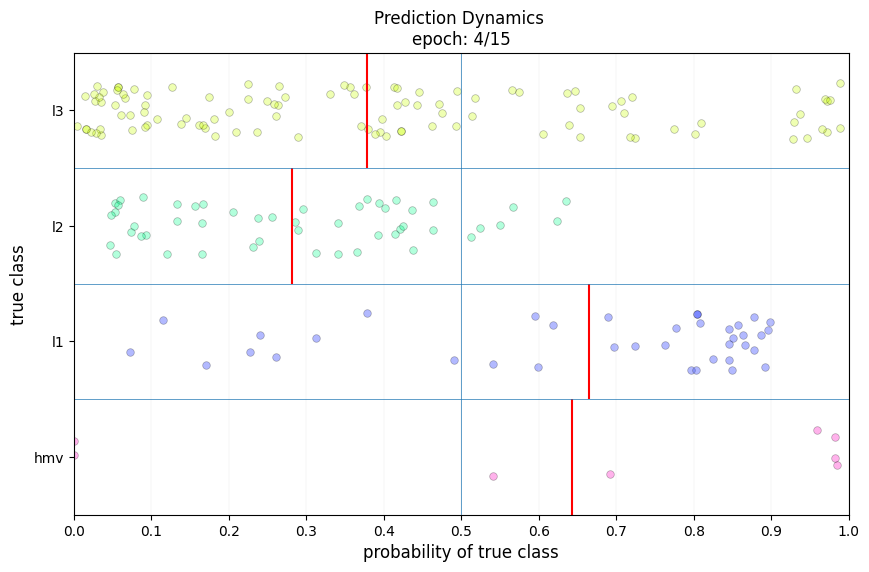

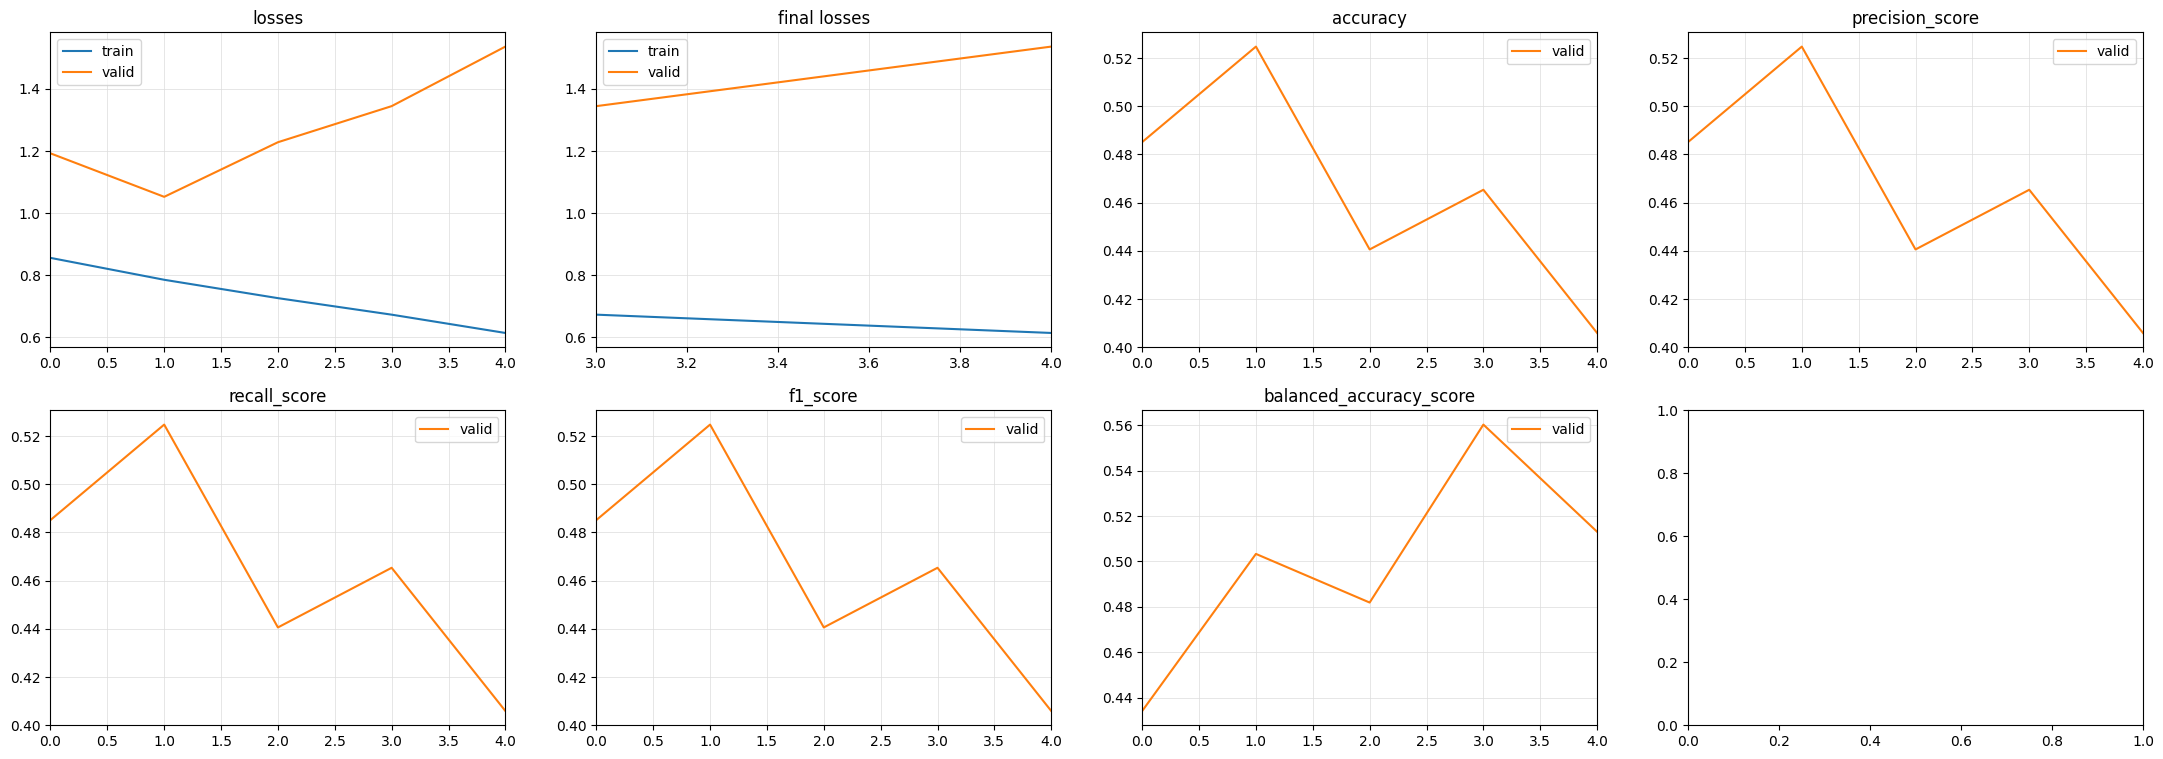

In [14]:
learn.fit_one_cycle(15,lr_max=learn.lr_find() , cbs=callbacks);

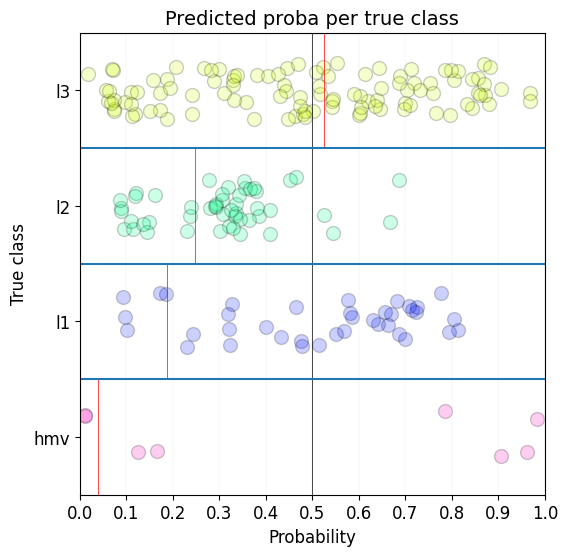

In [15]:
learn.show_probas()

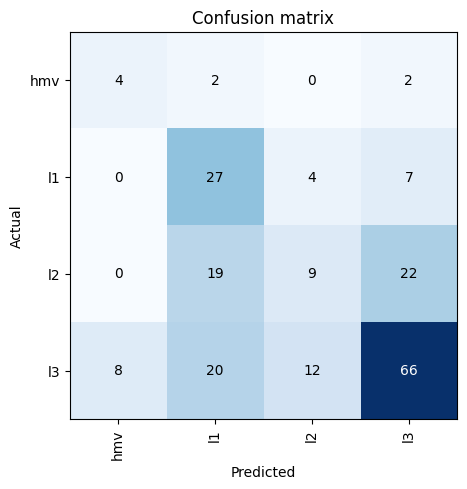

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [17]:
interp.most_confused(min_val=3)

[('l2', 'l3', 22),
 ('l3', 'l1', 20),
 ('l2', 'l1', 19),
 ('l3', 'l2', 12),
 ('l3', 'hmv', 8),
 ('l1', 'l3', 7),
 ('l1', 'l2', 4)]